# Sizing an Electrical Low-Voltage Network

In [1]:
import math

from python_electric import Quantity, VoltReference
from python_electric import calc
from python_electric.materials import (
    ConductorMaterials,
    InsulationMaterials
)
from python_electric.sizing import (
    Transformer,
    BusBars,
    ThreePhaseCable,
    Ambient,
    InstallationMethods,
    CableMounting,
    CableArrangement,
)

Q_ = Quantity


## Sizing Components

In [2]:
U_line = Q_(400, 'V')
U_phase = U_line / math.sqrt(3)

### Transformer

In [3]:
transformer = Transformer(
    S_nom=Q_(630, 'kVA'),
    U_line_pri=Q_(11, 'kV'),
    U_line=U_line,
    u_cc=Q_(4, 'pct'),
    P_Cu=Q_(4600, 'W'),
    P_load=Q_(325.76, 'kW'),
    cos_phi=0.9,
    name="T"
)

print(f"rated load current = {transformer.I_load.to('A'):~P.1f}")
print(f"maximum continuous current = {transformer.I_nom_sec.to('A'):~P.1f}")
print(f"nominal current = {transformer.I_nom.to('A'):~P.1f}")


rated load current = 522.4 A
maximum continuous current = 909.3 A
nominal current = 1000.0 A


### Bus Bars

In [4]:
# Note: bus bars must be sized based on the maximum continuous current of the transformer.

busbars = BusBars(
    S=Q_(499, 'mm ** 2'),
    I_z=Q_(1142, 'A'),
    L=Q_(4, 'm'),
    U_line=U_line,
    cos_phi=transformer.cos_phi,
    P_load=Q_(325.77, 'kW'),
    name="BB"
)

print(f"rated load current = {busbars.I_load.to('A'):~P.1f}")
print(f"nominal current = {busbars.I_nom.to('A'):~P.1f}")
print(f"current-carrying capacity = {busbars.I_z.to('A'):~P.1f}")


rated load current = 522.5 A
nominal current = 1000.0 A
current-carrying capacity = 1142.0 A


### Cable W1

In [5]:
cable_W1 = ThreePhaseCable(
    P_elec=Q_(108.83, 'kW'),
    P_mech=None,
    eta=1.0,
    cos_phi=0.7,
    L=Q_(37, 'm'),
    U_line=U_line,
    k_simul=0.8,
    k_ext=1.2,
    conductor_material=ConductorMaterials.COPPER,
    insulation_material=InsulationMaterials.XLPE,
    ambient=Ambient.AIR,
    T_amb=Q_(35, 'degC'),
    install_method=InstallationMethods.E,
    cable_mounting=CableMounting.PERFORATED_TRAY,
    cable_arrangement=CableArrangement.MULTICORE,
    num_circuits=5,
    harmonic3_content=0.0,
    sizing_based_on_I_nom=False,
    name="W1",
    S=None,
)

print(f"rated load current without correction = {cable_W1.I_load.to('A'):~P.1f}")
print(f"corrected rated load current = {cable_W1.I_load_corr.to('A'):~P.1f}")
# corrected by simultaneity and expansion factor
print(f"cross-sectional area of loaded conductors = {cable_W1.S.to('mm ** 2'):~P.0f}")
# cross-sectional area is based on corrected load current
print(f"nominal current for protective device = {cable_W1.I_nom.to('A'):~P.0f}")
print(f"current-carrying capacity of conductors = {cable_W1.I_z.to('A'):~P.0f}")


rated load current without correction = 224.4 A
corrected rated load current = 215.4 A
cross-sectional area of loaded conductors = 120 mm²
nominal current for protective device = 250 A
current-carrying capacity of conductors = 249 A


### Cable W2

In [6]:
cable_W2 = ThreePhaseCable(
    P_mech=Q_(15, 'kW'),
    eta=0.84,
    cos_phi=0.81,
    U_line=U_line,
    k_simul=1.0,
    k_ext=1.0,
    L=Q_(31, 'm'),
    conductor_material=ConductorMaterials.COPPER,
    insulation_material=InsulationMaterials.XLPE,
    ambient=Ambient.AIR,
    T_amb=Q_(30, 'degC'),
    install_method=InstallationMethods.E,
    cable_mounting=CableMounting.PERFORATED_TRAY,
    cable_arrangement=CableArrangement.MULTICORE,
    num_circuits=5,
    harmonic3_content=0.0,
    sizing_based_on_I_nom=False,
    name="W2",
    S=None
)

print(f"rated load current without correction = {cable_W2.I_load.to('A'):~P.1f}")
print(f"corrected rated load current = {cable_W2.I_load_corr.to('A'):~P.1f}")
print(f"cross-sectional area of conductors = {cable_W2.S.to('mm ** 2'):~P.0f}")
print(f"nominal current for protective device = {cable_W2.I_nom.to('A'):~P.0f}")
print(f"current-carrying capacity of conductors = {cable_W2.I_z.to('A'):~P.0f}")


rated load current without correction = 31.8 A
corrected rated load current = 31.8 A
cross-sectional area of conductors = 6 mm²
nominal current for protective device = 32 A
current-carrying capacity of conductors = 40 A


## Voltage Drop Calculations

### Stationary Operation

In [7]:
# No-load, line-to-line voltage at transfo secondary terminals
U_line_transf = Q_(420, 'V')

transformer.voltage_drop()
print(transformer.U_drop.to('V'))

# Line-to-line voltage at entry of bus bars
U_line_bar = U_line_transf - transformer.U_drop
print(U_line_bar.to('V'))

busbars.voltage_drop()
print(busbars.U_drop.to('V'))

# Line-to-line voltage at entry of main distribution board
U_line_main = U_line_bar - busbars.U_drop
print(U_line_main.to('V'))

cable_W1.voltage_drop()
print(cable_W1.U_drop.to('V'))

# Line-to-line voltage at entry of sub-distribution board
U_line_sub = U_line_main - cable_W1.U_drop
print(U_line_sub.to('V'))

# Relative voltage drop
print((1 - U_line_sub / U_line_transf).to('pct'))

5.563759577015995 volt
414.436240422984 volt
0.38912938952230636 volt
414.0471110334617 volt
1.5718392973612398 volt
412.47527173610047 volt
1.7916019675951245 percent


### Drum Press Machine Start-Up

#### Currents in Cables W1 and W2

In [8]:
# Rated current through cable W2 to the drum press machine
I_w2_nom = calc.phasor_from_cos(cable_W2.I_load.to('A').m, cable_W2.cos_phi)

# Total rated current through cable W1 to the sub-distribution board
I_w1_nom = calc.phasor_from_cos(cable_W1.I_load.to('A').m, cable_W1.cos_phi)

# Current from sub-distribution board that doesn't flow to the drum press machine
I_other = I_w1_nom - I_w2_nom
print(abs(I_other))

# During starting, the current drawn by the drum press machine is 6x the rated value and the cos phi drops to 0.45
I_w2_start = calc.phasor_from_cos(6 * cable_W2.I_load.to('A').m, 0.45)

# Total current through cable W1 when the drum press machine is starting
I_w1_start = I_w2_start + I_other

print(abs(I_w1_start))
print(abs(I_w2_start))


193.10921422645131
380.2490945353798
190.92270806535242


#### Voltage Drops across cables W1 and W2

In [9]:
# Voltage drop across cable W1 when the drum press machine is starting
U_drop_w1_start = calc.voltage_drop(
    R=cable_W1.Z["T_nom"][1].real.m,
    X=cable_W1.Z["T_nom"][1].imag.m,
    I=abs(I_w1_start),
    volt_ref=VoltReference.PH3_LINE_TO_LINE,
    cos_phi=calc.cosphi(I_w1_start)
)
U_drop_w1_start = Q_(U_drop_w1_start, 'V')
print(U_drop_w1_start)

# Line-to-line voltage at entry of sub-distribution board
U_line_sub = U_line_main - U_drop_w1_start
print(U_line_sub.to('V'))

# Voltage drop across cable W2 when the drum press machine is starting
U_drop_w2_start = calc.voltage_drop(
    R=cable_W2.Z["T_nom"][1].real.m,
    X=cable_W2.Z["T_nom"][1].imag.m,
    I=abs(I_w2_start),
    volt_ref=VoltReference.PH3_LINE_TO_LINE,
    cos_phi=calc.cosphi(I_w2_start)
)
U_drop_w2_start = Q_(U_drop_w2_start, 'V')
print(U_drop_w2_start)

# Line-to-line voltage at terminals of the drum press machine when it's starting
U_line_term = U_line_sub - U_drop_w2_start
print(U_line_term)

# Relative voltage drop
print((1 - U_line_term / U_line_transf).to('pct'))

4.2287400951324 volt
409.8183709383293 volt
18.154039621804557 volt
391.66433131652474 volt
6.746587781779823 percent


## Short-Circuit Calculations - part I: Maximum Short-Circuit Currents

### Network Impedances

#### MV Grid

In [10]:
from python_electric.equipment import PowerGrid, InductionMotor

mv_grid = PowerGrid(
    line_voltage=U_line,
    short_circuit_power=Q_(500, 'MVA'),
    voltage_factor=1.1,
    name="MV"
)

#### Induction Motor of Drum Press Machine

In [11]:
induction_motor = InductionMotor(
    nominal_voltage=U_line,
    nominal_current=Q_(32, 'A'),
    locked_rotor_current=6 * Q_(32, 'A'),
    P_m=Q_(15, 'kW'),
    efficiency=Q_(84, 'pct'),
    power_factor=0.81,
    name="M"
)

### Per-Unit Impedances

In [12]:
from python_electric.short_circuit.network import PerUnitSystem, get_impedances

pu_hv = PerUnitSystem(S_base=Q_(100, 'MVA'), U_base=Q_(11, 'kV'))
pu_lv = PerUnitSystem(S_base=Q_(100, 'MVA'), U_base=Q_(400, 'V'))

Z, Z_pu = get_impedances(
    components=[
        (mv_grid, pu_hv),
        (transformer, pu_lv),
        (busbars, pu_lv),
        (cable_W1, pu_lv),
        (cable_W2, pu_lv),
        (induction_motor, pu_lv)
    ],
    which_short_circuit="MAX"
)


### Positive Sequence Network

In [13]:
from python_electric.short_circuit.network import Network

nw1 = Network()
nw1.add_branch(Z_pu["MV"][1] + Z_pu["T"][1] + Z_pu["BB"][1], end_node_ID="1", has_source=True)
nw1.add_branch(Z_pu["W1"][1], start_node_ID="1", end_node_ID="2")
nw1.add_branch(Z_pu["W2"][1], start_node_ID="2", end_node_ID="3")
nw1.add_branch(Z_pu["M"][1], end_node_ID="3")

print(nw1)

                    1                   2                     3
1  1.277925+6.689002j  1.253722+6.665373j   0.777820+ 6.515148j
2  1.253722+6.665373j  4.640662+8.493973j   3.928488+ 8.499918j
3  0.777820+6.515148j  3.928488+8.499918j  58.622533+13.684006j


### Three-Phase Fault at Node 1 (Main Distribution Board)

In [14]:
from python_electric.short_circuit.faults import ThreePhaseFault
from python_electric.utils.formatting import PolarStringRepresentation as psr

sc_3ph = ThreePhaseFault(nw1, c=1.1)
sc_3ph.set_faulted_node("1")
Ik3_max_1_pu = sc_3ph.get_fault_current()
Ik3_max_1 = pu_lv.get_actual_current(Ik3_max_1_pu)
print(psr.from_complex_quantity(Ik3_max_1.to('A'), 2))

23314.50 A < -79.18°


### Three-Phase Fault at Node 2 (Sub-Distribution Board)

In [15]:
sc_3ph.set_faulted_node("2")
Ik3_max_2_pu = sc_3ph.get_fault_current()
Ik3_max_2 = pu_lv.get_actual_current(Ik3_max_2_pu)
print(psr.from_complex_quantity(Ik3_max_2.to('A'), 2))

16403.67 A < -61.35°


## Short-Circuit Calculations - part II: Minimum Short-Circuit Currents

### Per-Unit Impedances

In [16]:
Z, Z_pu = get_impedances(
    components=[
        (mv_grid, pu_hv),
        (transformer, pu_lv),
        (busbars, pu_lv),
        (cable_W1, pu_lv),
        (cable_W2, pu_lv),
        (induction_motor, pu_lv)
    ],
    which_short_circuit="MIN"
)

### Sequence Networks

#### Positive Sequence Network

In [17]:
nw1 = Network()
nw1.add_branch(Z_pu["MV"][1] + Z_pu["T"][1] + Z_pu["BB"][1], end_node_ID="1", has_source=True)
nw1.add_branch(Z_pu["W1"][1], start_node_ID="1", end_node_ID="2")
nw1.add_branch(Z_pu["W2"][1], start_node_ID="2", end_node_ID="3")
nw1.add_branch(Z_pu["M"][1], end_node_ID="3")

print(nw1)

                    1                   2                     3
1  1.324303+6.690044j  1.287007+6.661672j   0.586170+ 6.425876j
2  1.287007+6.661672j  6.384340+8.497316j   5.235627+ 8.646280j
3  0.586170+6.425876j  5.235627+8.646280j  85.955677+18.359046j


#### Negative Sequence Network

In [18]:
nw2 = Network()
nw2.add_branch(Z_pu["MV"][2] + Z_pu["T"][2] + Z_pu["BB"][2], end_node_ID="1")
nw2.add_branch(Z_pu["W1"][2], start_node_ID="1", end_node_ID="2")
nw2.add_branch(Z_pu["W2"][2], start_node_ID="2", end_node_ID="3")
nw2.add_branch(Z_pu["M"][2], end_node_ID="3")

print(nw2)

                    1                   2                     3
1  1.324303+6.690044j  1.287007+6.661672j   0.586170+ 6.425876j
2  1.287007+6.661672j  6.384340+8.497316j   5.235627+ 8.646280j
3  0.586170+6.425876j  5.235627+8.646280j  85.955677+18.359046j


#### Zero-Sequence Network

In [19]:
nw0 = Network()
nw0.add_branch(Z_pu["T"][0] + Z_pu["BB"][0], end_node_ID="1")
nw0.add_branch(Z_pu["W1"][0], start_node_ID="1", end_node_ID="2")
nw0.add_branch(Z_pu["W2"][0], start_node_ID="2", end_node_ID="3")
nw0.add_branch(Z_pu["M"][0], end_node_ID="3")

print(nw0)

                    1                     2                       3
1  1.317880+6.741917j   1.305564+ 6.733833j    1.080609+  6.675186j
2  1.305564+6.733833j  16.769492+12.291211j   16.148324+ 12.623942j
3  1.080609+6.675186j  16.148324+12.623942j  271.443884+ 25.458508j


### Single Line-To-Ground Fault at Node 1 (Main Distribution Board)

In [20]:
from python_electric.short_circuit.faults import LineToGroundFault

sc_1ph = LineToGroundFault([nw0, nw1, nw2], c=0.95)

sc_1ph.set_faulted_node("1")
Ik1_min_1_pu = sc_1ph.get_fault_current_abc()
print(psr.from_complex_vector(Ik1_min_1_pu, 2))

Ik1_min_1_pu = Ik1_min_1_pu[0]
Ik1_min_1 = pu_lv.get_actual_current(Ik1_min_1_pu)
print(psr.from_complex_quantity(Ik1_min_1.to('A'), 2))

[0.14 < -78.85°, 0.00 < 18.43°, 0.00 < 18.43°]
20057.42 A < -78.85°


### Single Line-To-Ground Fault at Node 2 (Sub-Distribution Board)

In [21]:
sc_1ph.set_faulted_node("2")
Ik1_min_2_pu = sc_1ph.get_fault_current_abc()
print(psr.from_complex_vector(Ik1_min_2_pu, 2))

Ik1_min_2_pu = Ik1_min_2_pu[0]
Ik1_min_2 = pu_lv.get_actual_current(Ik1_min_2_pu)
print(psr.from_complex_quantity(Ik1_min_2.to('A'), 2))

[0.07 < -44.75°, 0.00 < 75.96°, 0.00 < 90.00°]
9889.64 A < -44.75°


### Single Line-To-Ground Fault at Node 3 (Drum Press Machine)

In [22]:
sc_1ph.set_faulted_node("3")
Ik1_min_3_pu = sc_1ph.get_fault_current_abc()
print(psr.from_complex_vector(Ik1_min_3_pu, 2))

Ik1_min_3_pu = Ik1_min_3_pu[0]
Ik1_min_3 = pu_lv.get_actual_current(Ik1_min_3_pu)
print(psr.from_complex_quantity(Ik1_min_3.to('A'), 2))

[0.01 < -7.98°, 0.00 < 104.04°, 0.00 < 116.57°]
918.85 A < -7.98°


## Sizing of PE-Conductors

### Cable W1

In [23]:
from python_electric.protection import PEConductor

pe_conductor_W1 = PEConductor(
    conductor_material=ConductorMaterials.COPPER,
    insulation_material=InsulationMaterials.PVC,
    seperate=True
)

S_pe_W1 = pe_conductor_W1.cross_section_area(
    I_f=abs(Ik1_min_1),
    t_u=Q_(200, 'ms'),
    protected=False
)
print(f"csa PE-conductor cable W1 = {S_pe_W1.to('mm ** 2'):~P.0f}")

cable_W1.S_pe = S_pe_W1

csa PE-conductor cable W1 = 70 mm²


## Selecting Current-Protective Devices

In [24]:
from python_electric.protection import CircuitBreaker

### Bus Bars

In [25]:
busbars.connect_circuit_breaker(
    standard=CircuitBreaker.Standard.INDUSTRIAL,
    category=CircuitBreaker.Category.ADJUSTABLE,
    ultim_break_capacity=Q_(50, 'kA'),
    I_sc_max=abs(Ik3_max_1),
    I_sc_min=abs(Ik1_min_1),
    k_magn_trip=2.0,
)
print(busbars.circuit_breaker)


I_n     = 1000.0 A
I_r     = 522.5 A
I_nf    = 548.6 A
I_f     = 679.2 A
t_conv  = 2.0 h
I_m_min = 835.9 A
I_m_max = 1253.9 A
t_m_lim = 0.1 s


### Cable W1

In [26]:
cable_W1.connect_circuit_breaker(
    standard=CircuitBreaker.Standard.INDUSTRIAL,
    category=CircuitBreaker.Category.ADJUSTABLE,
    ultim_break_capacity=Q_(50, 'kA'),
    I_sc_max=abs(Ik3_max_1),
    I_sc_min=abs(Ik1_min_2),
    k_magn_trip=3.0
)
print(cable_W1.circuit_breaker)

I_n     = 250.0 A
I_r     = 224.4 A
I_nf    = 235.6 A
I_f     = 291.7 A
t_conv  = 2.0 h
I_m_min = 538.6 A
I_m_max = 807.9 A
t_m_lim = 0.1 s


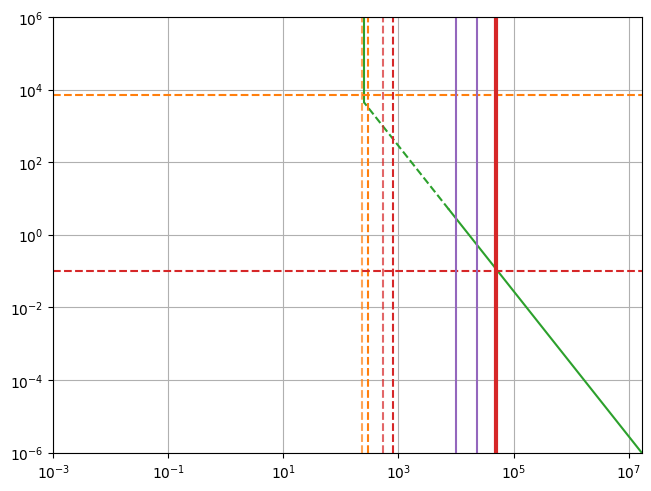

In [27]:
from python_electric.sizing.cable import plot_cable_characteristic

cable_chart = plot_cable_characteristic(cable_W1)
cable_chart.show()


### Cable W2

In [28]:
cable_W2.connect_circuit_breaker(
    standard=CircuitBreaker.Standard.INDUSTRIAL,
    category=CircuitBreaker.Category.D,
    ultim_break_capacity=Q_(20, 'kA'),
    I_sc_max=abs(Ik3_max_2),
    I_sc_min=abs(Ik1_min_3),
    E_through=Q_(5e5, 'A ** 2 * s')
)
print(cable_W2.circuit_breaker)

I_n     = 32.0 A
I_r     = 32.0 A
I_nf    = 33.6 A
I_f     = 41.6 A
t_conv  = 1.0 h
I_m_min = 307.2 A
I_m_max = 460.8 A
t_m_lim = 0.1 s


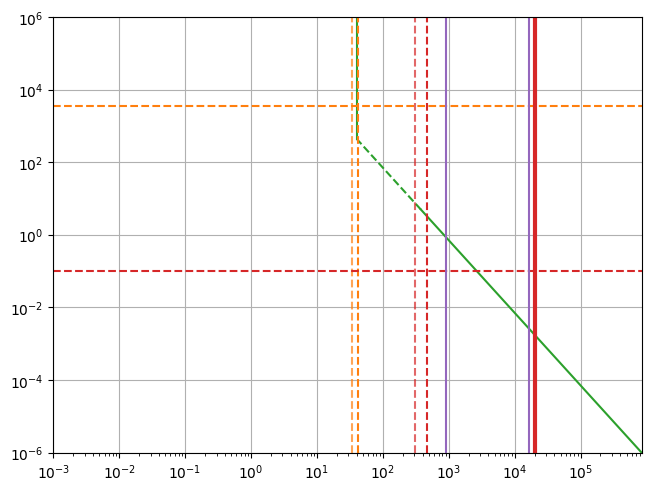

In [29]:
cable_chart = plot_cable_characteristic(cable_W2)
cable_chart.show()

In [30]:
from python_electric.sizing import check_selectivity

res = check_selectivity(cable_W1, cable_W2)
print(res)

SelectivityResult(total=True, exists=True, t_trip_max=<Quantity(187.400774, 'millisecond')>, t_margin=<Quantity(87.4007736, 'millisecond')>)


## Checking Protection against Indirect Contact

### Cable W1

In [31]:
res = cable_W1.check_indirect_contact_protection(final_circuit=False)
print(f"maximum cable length = {res.L_max.to('m'):~P.1f}")
print(f"maximum contact duration: {res.t_c_max.to('ms'):~P.0f}")

maximum cable length = 454.4 m
maximum contact duration: 187 ms


### Cable W2

In [32]:
res = cable_W2.check_indirect_contact_protection()
print(f"maximum cable length = {res.L_max.to('m'):~P.1f}")
print(f"maximum allowable resistance of PE-conductor = {res.R_pe_max.to('ohm'):~P.1f}")
print(f"maximum contact duration: {res.t_c_max.to('ms'):~P.0f}")

maximum cable length = 54.1 m
maximum allowable resistance of PE-conductor = 0.2 Ω
maximum contact duration: 200 ms


### Earthing Resistance (Indirect Contact of Extraneous Conductive Part)

In [34]:
import python_electric.protection.earthing_system as earthing_system

res = earthing_system.TN.check_earthing_resistance(
    U_phase=U_phase,
    R_b=Q_(30, 'ohm'),
    final_circuit=False
)
print(f"maximum contact duration: {res.t_c_max.to('ms'):~P.0f}")
print(f"maximum allowable earthing resistance: {res.R_b_max.to('ohm'):~P.1f}")

maximum contact duration: 75 ms
maximum allowable earthing resistance: 0.6 Ω
